# Analyze Visium fluorescence data | CellProfiler integration

In this tutorial we show how to use squidpy with functions of [cellprofiler](https://cellprofiler.org) pipelines for image processing and feature extraction.   

Cellprofiler is typically used via it's GUI interface to build image processing pipelines.
First download and install Cellprofiler from the [download page](https://github.com/CellProfiler/CellProfiler). Check issues on the [CellProfiler Github](https://github.com/CellProfiler/CellProfiler/issues) in case of installation problems (can be tricky).   

Note: In the future Cellprofiler functions will also be accessible via python code (according announcements of the Cellprofiler team). Since this is not publicly well documented yet we'll restrict this tutorial to the laborious way of saving intermediate files to bridge between squidpy and Cellprofiler. For infos how to use the `cellprofiler-core` package for python integration the following [link](https://github.com/CellProfiler/CellProfiler/wiki/CellProfiler-as-a-Python-package) might be helpful.   

We'll go through the following steps:
1. Load visium fluorescence data
2. Segment cells in squidpy
3. Calculate CellProfiler's granularity features for image crops of visium spots
4. Compute clustering on the image features in squidpy

# Import packages & data

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
import matplotlib.pyplot as plt
from pathlib import Path
import itertools

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
sc.set_figure_params(facecolor="white", figsize=(8, 8))

# load the pre-processed dataset
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

scanpy==1.8.0.dev88+g525f08f6 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.2.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3
squidpy==1.0.0


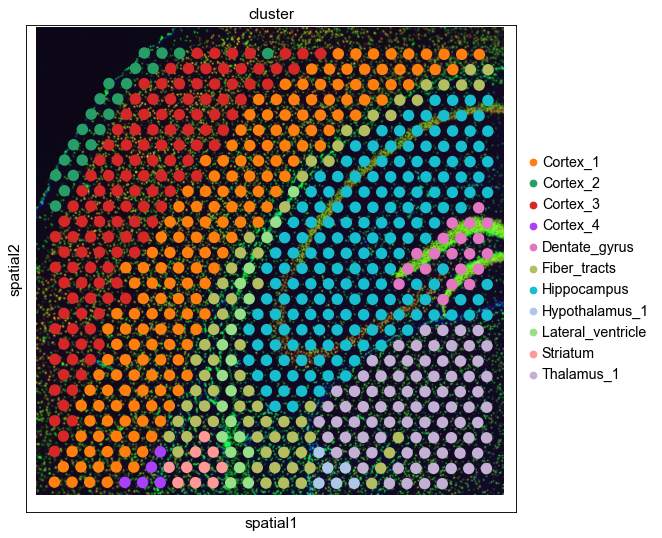

In [2]:
sc.pl.spatial(adata, color="cluster")

# Setup files
Create some arbitrary empty base directory `BASE_DIR` and a folder `"tmp_imgs"` in it.

In [6]:
BASE_DIR = './squidpy_tutorial_cellprofiler/'
Path(BASE_DIR).mkdir(parents=True, exist_ok=True)
Path(BASE_DIR+'tmp_imgs/').mkdir(parents=True, exist_ok=True)

Open the CellProfiler GUI App. A new project should open automatically:
![image1](tutorial_cellprofiler_images/01CP_new_project.png)    
Save the project in `BASE_DIR`    
![image2](tutorial_cellprofiler_images/02CP_save_project.png)    

# Image segmentation

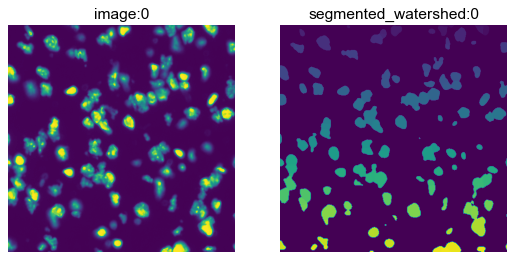

In [3]:
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
    sigma=[2,2,0,0],
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel_ids=0, chunks=1000)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(2000, 2000, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

# Save image crops and segmentations
For each visium spot we generate crops:

/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


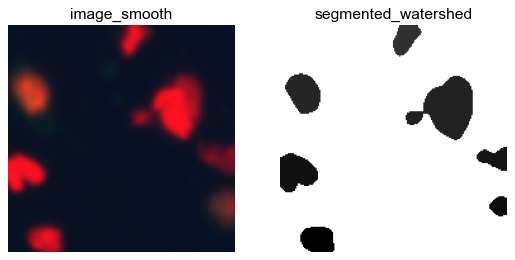

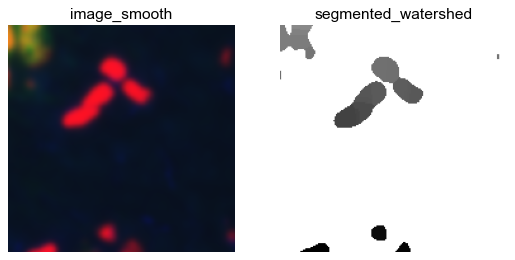

In [4]:
for crop,obs in itertools.islice(img.generate_spot_crops(adata, obs_names=adata.obs_names, return_obs=True, as_array=False), 2):
    fig, axes = plt.subplots(1, 2)
    crop.show('image_smooth', ax=axes[0])
    crop.show('segmented_watershed', ax=axes[1], cmap='Greys')
    plt.show() 

Save the fluorescence image and the segmentations of each crop

In [166]:
for crop,obs in img.generate_spot_crops(adata, obs_names=adata.obs_names, return_obs=True, as_array=False):
    Image.fromarray((np.array(crop['image_smooth'])* 255).astype(np.uint8)).save(BASE_DIR+f'tmp_imgs/image_{obs}.png')
    Image.fromarray(np.array(crop['segmented_watershed'][:,:,0])).save(BASE_DIR+f'tmp_imgs/segments_{obs}.tif')

# CellProfiler Pipeline: Calculate Image Features
1. CP-Pipeline `Images`: Drag and Drop the folder `BASE_DIR+"tmp_imgs"` into CellProfiler   
![image3](tutorial_cellprofiler_images/03CP_import_images.png)   
2. CP-Pipeline `NamesAndTypes`: Declare to load crops as color images and segmentations as objects. Crops and segmentations files are aligned automatically.   
![image4](tutorial_cellprofiler_images/04CP_NamesAndTypes.png)   
3. Convert image crops to gray images: Add `ColorToGray` module and define parameters.   
![image5](tutorial_cellprofiler_images/05CP_Create_ColorToGray.png)   
![image6](tutorial_cellprofiler_images/06CP_ColorToGray.png)   
4. Measure CellProfiler's Granularity features within segments for each crop: Add `MeasureGranularity` module and define parameters.   
![image7](tutorial_cellprofiler_images/07CP_Create_Granularity.png)   
![image8](tutorial_cellprofiler_images/08CP_Granularity.png)   
5. Export results to csv.   
![image9](tutorial_cellprofiler_images/09CP_Create_Export.png)   
![image10](tutorial_cellprofiler_images/10CP_Export.png)   
6. Run CellProfiler Pipeline (takes several minutes).   
![image11](tutorial_cellprofiler_images/11CP_Run.png)   
You can delete the images in `BASE_DIR+"tmp_imgs/"` now.

# Cluster features
Load CellProfiler output of Granularity features of each visium spot and rearrange the output for `adata.obsm`.

In [ ]:
# load Cellprofiler output
df = pd.read_csv(BASE_DIR+'/squidpy_Image.csv')
# set obs names as index
df.index = df['FileName_Spot_Crop'].apply(lambda s: s.split("_")[1].split(".")[0])
df.index.name = "obs"
# Get the measured Granularity features and rename them
features = [f'{stat}_Segments_Granularity_{i}_SpotGray' for stat in ['Mean','StDev'] for i in range(1,17)]
df = df[features]
df.columns = [s.split("_")[0]+s.split("_")[2]+s.split("_")[3] for s in df.columns]

In [8]:
df.head()

,MeanGranularity1,MeanGranularity2,MeanGranularity3,MeanGranularity4,MeanGranularity5,MeanGranularity6,MeanGranularity7,MeanGranularity8,MeanGranularity9,MeanGranularity10,...,StDevGranularity7,StDevGranularity8,StDevGranularity9,StDevGranularity10,StDevGranularity11,StDevGranularity12,StDevGranularity13,StDevGranularity14,StDevGranularity15,StDevGranularity16
obs,,,,,,,,,,,,,,,,,,,,,
AAACGAGACGGTTGAT-1,35.513010,8.562676,26.546550,14.187602,7.629247,3.334912,2.057867,0.623025,0.258596,0.336359,...,1.615079,0.490024,0.284772,0.251887,0.000000,0.000000,0.000000,0.196002,0.000000,0.0
AAAGGGATGTAGCAAG-1,34.115594,24.218906,20.290728,4.457829,0.832083,4.670038,3.027418,1.872175,0.694657,0.642282,...,4.840615,2.934531,1.024722,1.045698,0.174283,0.783332,0.156181,0.156181,0.156181,0.0
AAATGGCATGTCTTGT-1,35.680015,15.708321,15.551889,8.760072,5.392920,7.575340,5.474114,0.876559,0.121634,0.000000,...,2.082841,1.640197,0.227598,0.000000,0.392862,0.785725,1.172769,0.234967,0.000000,0.0
AAATGGTCAATGTGCC-1,27.243626,6.490712,9.602902,3.852946,3.829664,0.000000,0.000000,7.289044,8.814914,12.036803,...,0.000000,9.020724,6.604276,3.711367,1.988622,1.063700,0.303914,0.075979,0.151957,0.0
AAATTAACGGGTAGCT-1,33.575662,12.159623,21.226989,19.807115,8.313644,2.021116,0.463706,0.716149,0.283679,0.283679,...,0.328582,0.264752,0.219188,0.219188,0.000000,0.000000,0.219188,0.000000,0.000000,0.0


Load image features into `adata.obsm["features"]` and compute leiden clustering

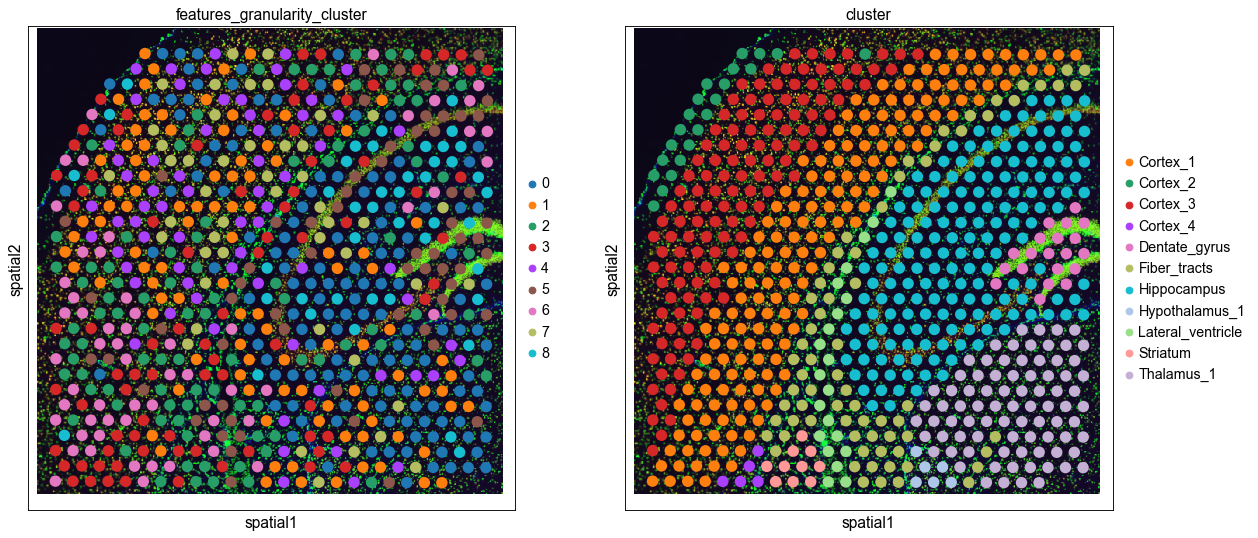

In [159]:
def cluster_features(features: pd.DataFrame):
    """Calculate leiden clustering of features.
    """
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]

# Save feature in adata.obsm
adata.obsm["features"] = df.loc[adata.obs_names].copy()

# Calculate leiden clustering
adata.obs["features_granularity_cluster"] = cluster_features(adata.obsm["features"])

# Plot clusterings
sc.pl.spatial(
    adata,
    color=[
        "features_granularity_cluster",
        "cluster",
    ],
    ncols=2,
)

We see that e.g. the blue cluster is prominent in the Hippocampus and the Thalamus, and the brown cluster is prominent in dense regions like Dentate gyrus.